In [ ]:
# !pip install optuna
# import optuna
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.utils.data as utils
import time
import datetime as dt
from numpy import array
from numpy import hstack
import warnings
from sklearn.model_selection import train_test_split
import torch.optim as optim

#3 Variable Multivariate

In [ ]:
#ISAT.JK
isat = pd.read_csv("ISAT.csv")
isat["Date"] = pd.to_datetime(isat["Date"])
isat = isat.set_index('Date')
isat = isat['2009-10-10' :'2021-09-24']
isat = isat.dropna().reset_index()

#TLKM.JK
tlkm = pd.read_csv("TLKM.csv")
tlkm["Date"] = pd.to_datetime(tlkm["Date"])
tlkm = tlkm.set_index('Date')
tlkm = tlkm['2009-10-10' :'2021-09-24']
tlkm = tlkm.dropna().reset_index()

#EXCL.JK
xl = pd.read_csv("EXCL.csv")
xl["Date"] = pd.to_datetime(xl["Date"])
xl = xl.set_index('Date')
xl = xl['2009-10-10' :'2021-09-24']
xl = xl.dropna().reset_index()
# data = data[:22]

In [ ]:
print(len(isat))
print(len(xl))
print(len(tlkm))

2964
2964
2964


In [ ]:
priceIsat = isat[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
priceIsat['Close'] = scaler.fit_transform(priceIsat['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
priceTlkm = tlkm[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
priceTlkm['Close'] = scaler.fit_transform(priceTlkm['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
priceXl = xl[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
priceXl['Close'] = scaler.fit_transform(priceXl['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##Create Sequence Data

In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
in_seq1 = priceIsat.to_numpy()
in_seq2 = priceTlkm.to_numpy()
in_seq3 = priceXl.to_numpy()
out_seq = priceIsat.to_numpy()
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3, out_seq))

In [ ]:
X, y = split_sequences(dataset, 20)

In [ ]:
# num_of_rows = int(len(X) * 0.8)
# x_train = X[:num_of_rows] 
# y_train = y[:num_of_rows]
# x_test = X[num_of_rows:] 
# y_test = y[num_of_rows:] 

In [ ]:
X.shape

(2945, 20, 3)

In [ ]:
y.shape

(2945,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.0101, shuffle=False)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2915, 20, 3), (30, 20, 3), (2915,), (30,))

In [ ]:
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

##Build Model

In [ ]:
class BiLSTM(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        self.linear = nn.Linear(2*hidden_dim, output_dim)
        self.linear2 = nn.Linear(63,1)
        
    def forward(self, x, y):
        batch_size, seq_len, _ = x.size()
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        out1, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out1 = out1[:, -1, :]
        out1 = self.linear(out1)
        out1 = out1.unsqueeze(2).expand(-1, -1, 3)
        out2 = y
        out = torch.cat((out2,out1),dim=1)
        out = out.contiguous().view(batch_size,-1)
        out = self.linear2(out)
        # out = F.relu(out)
        # print(out.shape)
        return out

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean((np.abs(Y_Predicted-Y_actual)/Y_actual))*100
    return mape

##Train Multivariate Model

In [ ]:
model = BiLSTM(input_dim=3, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)
params = list(model.state_dict().keys())

In [ ]:
import time
num_epochs = 2000
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train,x_train)
    loss = criterion(y_train_pred, y_train)
    if t%100==0 or t==1999:
      print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
     
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([2915])) that is different to the input size (torch.Size([2915, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch  0 MAE:  0.5292615294456482
Epoch  100 MAE:  0.1898345798254013
Epoch  200 MAE:  0.18937188386917114
Epoch  300 MAE:  0.1893015056848526
Epoch  400 MAE:  0.18926136195659637
Epoch  500 MAE:  0.1898232251405716
Epoch  600 MAE:  0.19023077189922333
Epoch  700 MAE:  0.19026432931423187
Epoch  800 MAE:  0.2737109959125519
Epoch  900 MAE:  0.19112899899482727
Epoch  1000 MAE:  0.1945371925830841
Epoch  1100 MAE:  0.19270403683185577
Epoch  1200 MAE:  0.19237352907657623
Epoch  1300 MAE:  0.19537235796451569
Epoch  1400 MAE:  0.19332373142242432
Epoch  1500 MAE:  0.19271790981292725
Epoch  1600 MAE:  0.19561348855495453
Epoch  1700 MAE:  0.1935078650712967
Epoch  1800 MAE:  0.19280949234962463
Epoch  1900 MAE:  0.19567517936229706
Epoch  1999 MAE:  0.19567763805389404
Training time: 6564.989830732346


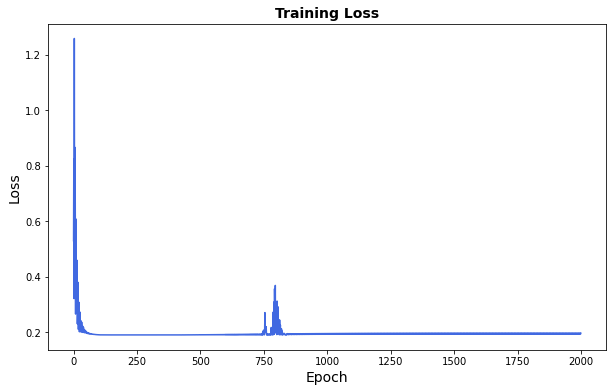

In [ ]:
import seaborn as sns
fig = plt.figure()
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(10)

##Predict Test Data

In [ ]:
y_test_pred = model(x_test,x_test)

In [ ]:
y_test_pred.shape

torch.Size([30, 1])

In [ ]:
# y_pred_detached = y_test_pred.clone()
# y_pred_detached = y_pred_detached.detach().numpy()
# mae_3variable = mean_absolute_error(y_test[-20:], y_test_pred)

In [ ]:
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.reshape(-1,1).detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.reshape(-1,1).detach().numpy())

In [ ]:
mae_3variable = mean_absolute_error(y_test, y_test_pred)

In [ ]:
predicted = pd.DataFrame({'Predicted': y_test_pred[:, 0]})
df3 = isat.copy()
df3 = df3.set_index('Date')
df3 = df3[-30:]
df3 = df3[['Close']]
df3.rename(columns = {'Close':'Actual'}, inplace = True)
df3['Predicted (3 Variable)'] = predicted.values

##Plotting Test Result

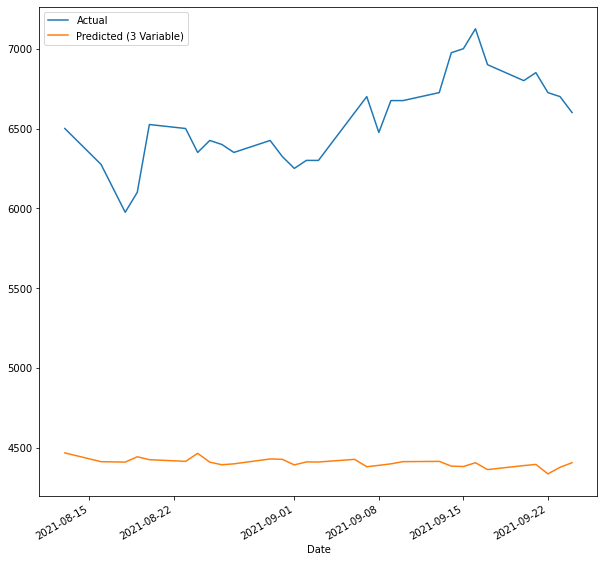

In [ ]:
df3.plot(y=["Actual","Predicted (3 Variable)"],
        kind="line", figsize=(10, 10),use_index=True)

In [ ]:
tlkmDenorm = scaler.inverse_transform(priceTlkm)
mean_absolute_error(tlkmDenorm[-30:], y_test_pred)

439.23454070487315

In [ ]:
isatDenorm = scaler.inverse_transform(priceIsat)
mean_absolute_error(isatDenorm[-30:], y_test_pred)

1904.1355696039525

In [ ]:
xlDenorm = scaler.inverse_transform(priceXl)
mean_absolute_error(xlDenorm[-30:], y_test_pred)

1650.5179524739583

#11 Variable Multivariat

##Prepare Dataset

In [ ]:
filenames = ['ADRO.csv','BBCA.csv','BBRI.csv','BMRI.csv','CENT.csv','EXCL.csv','GOLD.csv',
             'ISAT.csv','PGAS.csv','PTBA.csv','TLKM.csv']

In [ ]:
for files in filenames:
  globals()[f"{files[:4].lower()}"] = pd.read_csv(files,parse_dates=['Date'])
  globals()[f"{files[:4].lower()}"] = globals()[f"{files[:4].lower()}"].set_index('Date')
  globals()[f"{files[:4].lower()}"] = globals()[f"{files[:4].lower()}"]['2010-07-07' :'2021-09-24']
  globals()[f"{files[:4].lower()}"] = globals()[f"{files[:4].lower()}"].dropna().reset_index()
  
bbca.drop(2226,inplace=True)
gold.drop(2226, inplace= True)

In [ ]:
# warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
scaler = MinMaxScaler(feature_range=(0, 1))
for files in filenames:
  globals()[f"price_{files[:4].lower()}"] = globals()[f"{files[:4].lower()}"][['Close']]
  globals()[f"price_{files[:4].lower()}"]['Close'] = scaler.fit_transform(globals()[f"price_{files[:4].lower()}"]['Close'].values.reshape(-1,1))

In [ ]:
# i = 1
# for files in filenames:
#   globals()[f"in_seq{i}"] = globals()[f"price_{files[:4].lower()}"].to_numpy()
#   globals()[f"in_seq{i}"] = globals()[f"in_seq{i}"].reshape(len(globals()[f"in_seq{i}"]),1)
#   i+=1
# out_seq = price_isat.to_numpy()
# out_seq = out_seq.reshape(len(out_seq), 1)
# dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, out_seq))

In [ ]:
# def split_sequences(sequences, n_steps):
#     X, y = list(), list()
#     for i in range(len(sequences)):
#         # find the end of this pattern
#         end_ix = i + n_steps
#         # check if we are beyond the dataset
#         if end_ix > len(sequences):
#             break
#         # gather input and output parts of the pattern
#         seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
#         X.append(seq_x)
#         y.append(seq_y)
#     return array(X), array(y)

In [ ]:
# X, y = split_sequences(dataset, 20)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.0108, shuffle=False)
# x_train = torch.Tensor(x_train)
# x_test = torch.Tensor(x_test)
# y_train = torch.Tensor(y_train)
# y_test = torch.Tensor(y_test)

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(30);
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
for files in filenames:
  globals()[f"x_train_{files[:4].lower()}"], globals()[f"y_train_{files[:4].lower()}"], globals()[f"x_test_{files[:4].lower()}"], globals()[f"y_test_{files[:4].lower()}"] = split_data(globals()[f"price_{files[:4].lower()}"],21)
  globals()[f"x_train_{files[:4].lower()}"] = torch.from_numpy(globals()[f"x_train_{files[:4].lower()}"]).type(torch.Tensor)
  globals()[f"y_train_{files[:4].lower()}"] = torch.from_numpy(globals()[f"y_train_{files[:4].lower()}"]).type(torch.Tensor)
  globals()[f"x_test_{files[:4].lower()}"] = torch.from_numpy(globals()[f"x_test_{files[:4].lower()}"]).type(torch.Tensor)
  globals()[f"y_test_{files[:4].lower()}"] = torch.from_numpy(globals()[f"y_test_{files[:4].lower()}"]).type(torch.Tensor)

##Build Model

In [ ]:
# class BiLSTM(nn.Module):
  
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(BiLSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
#         self.linear = nn.Linear(2*hidden_dim, output_dim)
#         self.linear2 = nn.Linear(451,1)
        
#     def forward(self, x, y, future_preds=0):
#         batch_size, seq_len, _ = x.size()
#         h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
#         c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
#         out1, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out1 = out1[:, -1, :]
#         out1 = self.linear(out1)
#         out1 = out1.unsqueeze(2).expand(-1, -1, 11)
#         out2 = y
#         out = torch.cat((out2,out1),dim=1)
#         out = out.contiguous().view(batch_size,-1)
#         out = self.linear2(out)
#         return out

In [ ]:
class BiLSTM(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        self.linear = nn.Linear(2*hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

##Hyperparameter Tuning

In [ ]:
def build_model(params):
  model = BiLSTM(input_dim=11, hidden_dim=params['hidden'], output_dim=1, num_layers=params['lstm'])
  return model

def train_model(params,model):
  num_epochs = 300
  criterion = torch.nn.L1Loss()
  hist = np.zeros(num_epochs)
  min_loss = 100
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=0.001)
  for t in range(num_epochs):
    y_train_pred = model(x_train,x_train)
    loss = criterion(y_train_pred, y_train)
    if t%100==0 or t == 299:
        print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    min_loss = hist.min()
    # print("Hidden Layer:{}, LSTM: {}, Optimizer: {}, Min Mae: {}".format(model.hidden_dim, model.num_layers, optimizer.__class__.__name__, min_loss))
  return min_loss

def objective(trial):
     params = {
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'lstm': trial.suggest_int("lstm", 1, 3, 1),
              'hidden': trial.suggest_int("hidden",8, 32, 8)
              }
    
     model = build_model(params)
    
     loss = train_model(params, model)

     return loss

In [ ]:
params = {
              'optimizer': ["Adam", "RMSprop", "SGD"],
              'lstm': [1,2,3],
              'hidden': [8,16,32]
              }
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.GridSampler(params))
study.optimize(objective, n_trials=27)

[I 2022-06-08 08:05:56,134] A new study created in memory with name: no-name-81b2da9f-0bcb-4dfa-8ce1-ed0f028c9a8e


Epoch  0 MAE:  0.41811126470565796
Epoch  100 MAE:  0.21053901314735413
Epoch  200 MAE:  0.20801115036010742
Epoch  299 MAE:  0.20677751302719116


[I 2022-06-08 08:09:44,639] Trial 0 finished with value: 0.20677751302719116 and parameters: {'optimizer': 'SGD', 'lstm': 2, 'hidden': 16}. Best is trial 0 with value: 0.20677751302719116.


Epoch  0 MAE:  1.124743103981018
Epoch  100 MAE:  0.25646787881851196
Epoch  200 MAE:  0.2159622311592102
Epoch  299 MAE:  0.29401928186416626


[I 2022-06-08 08:15:18,692] Trial 1 finished with value: 0.2021394670009613 and parameters: {'optimizer': 'RMSprop', 'lstm': 3, 'hidden': 16}. Best is trial 1 with value: 0.2021394670009613.


Epoch  0 MAE:  0.6502150893211365
Epoch  100 MAE:  0.2026899755001068
Epoch  200 MAE:  0.2024250030517578
Epoch  299 MAE:  0.20976164937019348


[I 2022-06-08 08:23:39,271] Trial 2 finished with value: 0.19949254393577576 and parameters: {'optimizer': 'RMSprop', 'lstm': 2, 'hidden': 32}. Best is trial 2 with value: 0.19949254393577576.


Epoch  0 MAE:  0.34387078881263733
Epoch  100 MAE:  0.20869117975234985
Epoch  200 MAE:  0.2062987983226776
Epoch  299 MAE:  0.20537184178829193


[I 2022-06-08 08:27:25,429] Trial 3 finished with value: 0.20537184178829193 and parameters: {'optimizer': 'SGD', 'lstm': 3, 'hidden': 8}. Best is trial 2 with value: 0.19949254393577576.


Epoch  0 MAE:  0.7638319730758667
Epoch  100 MAE:  0.2100173532962799
Epoch  200 MAE:  0.2076886147260666
Epoch  299 MAE:  0.20656900107860565


[I 2022-06-08 08:30:00,074] Trial 4 finished with value: 0.20656900107860565 and parameters: {'optimizer': 'SGD', 'lstm': 2, 'hidden': 8}. Best is trial 2 with value: 0.19949254393577576.


Epoch  0 MAE:  0.5622649788856506
Epoch  100 MAE:  0.20434527099132538
Epoch  200 MAE:  0.19924604892730713
Epoch  299 MAE:  0.19902421534061432


[I 2022-06-08 08:33:46,783] Trial 5 finished with value: 0.1990230232477188 and parameters: {'optimizer': 'Adam', 'lstm': 1, 'hidden': 32}. Best is trial 5 with value: 0.1990230232477188.


Epoch  0 MAE:  0.850306510925293
Epoch  100 MAE:  0.20445981621742249
Epoch  200 MAE:  0.20350384712219238


[I 2022-06-08 08:35:35,201] Trial 6 finished with value: 0.2025654911994934 and parameters: {'optimizer': 'Adam', 'lstm': 1, 'hidden': 16}. Best is trial 5 with value: 0.1990230232477188.


Epoch  299 MAE:  0.2025654911994934
Epoch  0 MAE:  0.5334216952323914
Epoch  100 MAE:  0.218997985124588
Epoch  200 MAE:  0.20230598747730255
Epoch  299 MAE:  0.19984136521816254


[I 2022-06-08 08:39:13,132] Trial 7 finished with value: 0.19984136521816254 and parameters: {'optimizer': 'RMSprop', 'lstm': 2, 'hidden': 16}. Best is trial 5 with value: 0.1990230232477188.


Epoch  0 MAE:  0.4301740825176239
Epoch  100 MAE:  0.2031211405992508
Epoch  200 MAE:  0.19975370168685913
Epoch  299 MAE:  0.19950227439403534


[I 2022-06-08 08:43:02,029] Trial 8 finished with value: 0.19950227439403534 and parameters: {'optimizer': 'RMSprop', 'lstm': 3, 'hidden': 8}. Best is trial 5 with value: 0.1990230232477188.


Epoch  0 MAE:  0.3842417299747467
Epoch  100 MAE:  0.20008030533790588
Epoch  200 MAE:  0.19906091690063477
Epoch  299 MAE:  0.19893494248390198


[I 2022-06-08 08:48:34,450] Trial 9 finished with value: 0.19893494248390198 and parameters: {'optimizer': 'Adam', 'lstm': 3, 'hidden': 16}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.6265724897384644
Epoch  100 MAE:  0.2059876173734665
Epoch  200 MAE:  0.20369607210159302
Epoch  299 MAE:  0.19918960332870483


[I 2022-06-08 09:01:54,811] Trial 10 finished with value: 0.19915053248405457 and parameters: {'optimizer': 'Adam', 'lstm': 3, 'hidden': 32}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.42782485485076904
Epoch  100 MAE:  0.2044783979654312
Epoch  200 MAE:  0.20588147640228271
Epoch  299 MAE:  0.20027290284633636


[I 2022-06-08 09:04:34,308] Trial 11 finished with value: 0.20027290284633636 and parameters: {'optimizer': 'RMSprop', 'lstm': 2, 'hidden': 8}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.4394996166229248
Epoch  100 MAE:  0.20611339807510376
Epoch  200 MAE:  0.20501266419887543
Epoch  299 MAE:  0.20457550883293152


[I 2022-06-08 09:10:30,664] Trial 12 finished with value: 0.20457550883293152 and parameters: {'optimizer': 'SGD', 'lstm': 3, 'hidden': 16}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.6282947063446045
Epoch  100 MAE:  0.21046271920204163
Epoch  200 MAE:  0.20834310352802277
Epoch  299 MAE:  0.2073473185300827


[I 2022-06-08 09:14:24,405] Trial 13 finished with value: 0.2073473185300827 and parameters: {'optimizer': 'SGD', 'lstm': 1, 'hidden': 32}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.6023129820823669
Epoch  100 MAE:  0.1995556503534317
Epoch  200 MAE:  0.19899621605873108
Epoch  299 MAE:  0.1989387571811676


[I 2022-06-08 09:18:00,713] Trial 14 finished with value: 0.19893771409988403 and parameters: {'optimizer': 'Adam', 'lstm': 2, 'hidden': 16}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.3113913834095001
Epoch  100 MAE:  0.21003635227680206
Epoch  200 MAE:  0.20229768753051758


[I 2022-06-08 09:19:27,040] Trial 15 finished with value: 0.20111532509326935 and parameters: {'optimizer': 'RMSprop', 'lstm': 1, 'hidden': 8}. Best is trial 9 with value: 0.19893494248390198.


Epoch  299 MAE:  0.20111532509326935
Epoch  0 MAE:  0.5974480509757996
Epoch  100 MAE:  0.21207399666309357
Epoch  200 MAE:  0.20940415561199188
Epoch  299 MAE:  0.20786726474761963


[I 2022-06-08 09:32:47,633] Trial 16 finished with value: 0.20786726474761963 and parameters: {'optimizer': 'SGD', 'lstm': 3, 'hidden': 32}. Best is trial 9 with value: 0.19893494248390198.


Epoch  0 MAE:  0.5074066519737244
Epoch  100 MAE:  0.20196713507175446
Epoch  200 MAE:  0.19903124868869781
Epoch  299 MAE:  0.19893482327461243


[I 2022-06-08 09:41:54,945] Trial 17 finished with value: 0.19893482327461243 and parameters: {'optimizer': 'Adam', 'lstm': 2, 'hidden': 32}. Best is trial 17 with value: 0.19893482327461243.


Epoch  0 MAE:  0.3944821357727051
Epoch  100 MAE:  0.20209600031375885
Epoch  200 MAE:  0.19919702410697937
Epoch  299 MAE:  0.19898167252540588


[I 2022-06-08 09:44:27,902] Trial 18 finished with value: 0.19898167252540588 and parameters: {'optimizer': 'Adam', 'lstm': 2, 'hidden': 8}. Best is trial 17 with value: 0.19893482327461243.


Epoch  0 MAE:  0.24708829820156097
Epoch  100 MAE:  0.19990164041519165
Epoch  200 MAE:  0.1990424543619156


[I 2022-06-08 09:45:51,915] Trial 19 finished with value: 0.19892650842666626 and parameters: {'optimizer': 'Adam', 'lstm': 1, 'hidden': 8}. Best is trial 19 with value: 0.19892650842666626.


Epoch  299 MAE:  0.19892650842666626
Epoch  0 MAE:  0.6725202798843384
Epoch  100 MAE:  0.2146848440170288
Epoch  200 MAE:  0.21026448905467987


[I 2022-06-08 09:47:15,142] Trial 20 finished with value: 0.2084392011165619 and parameters: {'optimizer': 'SGD', 'lstm': 1, 'hidden': 8}. Best is trial 19 with value: 0.19892650842666626.


Epoch  299 MAE:  0.2084392011165619
Epoch  0 MAE:  0.7590779066085815
Epoch  100 MAE:  0.20669852197170258
Epoch  200 MAE:  0.20485703647136688


[I 2022-06-08 09:49:04,795] Trial 21 finished with value: 0.20404665172100067 and parameters: {'optimizer': 'SGD', 'lstm': 1, 'hidden': 16}. Best is trial 19 with value: 0.19892650842666626.


Epoch  299 MAE:  0.20404665172100067
Epoch  0 MAE:  0.32542654871940613
Epoch  100 MAE:  0.21847259998321533
Epoch  200 MAE:  0.2028069943189621
Epoch  299 MAE:  0.202461376786232


[I 2022-06-08 10:03:11,128] Trial 22 finished with value: 0.202461376786232 and parameters: {'optimizer': 'RMSprop', 'lstm': 3, 'hidden': 32}. Best is trial 19 with value: 0.19892650842666626.


Epoch  0 MAE:  0.6583175659179688
Epoch  100 MAE:  0.20378606021404266
Epoch  200 MAE:  0.2025826871395111
Epoch  299 MAE:  0.20084477961063385


[I 2022-06-08 10:05:03,963] Trial 23 finished with value: 0.20084477961063385 and parameters: {'optimizer': 'RMSprop', 'lstm': 1, 'hidden': 16}. Best is trial 19 with value: 0.19892650842666626.


Epoch  0 MAE:  0.8115749359130859
Epoch  100 MAE:  0.21602390706539154
Epoch  200 MAE:  0.21008847653865814
Epoch  299 MAE:  0.2081085443496704


[I 2022-06-08 10:15:16,261] Trial 24 finished with value: 0.2081085443496704 and parameters: {'optimizer': 'SGD', 'lstm': 2, 'hidden': 32}. Best is trial 19 with value: 0.19892650842666626.


Epoch  0 MAE:  0.23452480137348175
Epoch  100 MAE:  0.19955754280090332
Epoch  200 MAE:  0.19892190396785736
Epoch  299 MAE:  0.19886864721775055


[I 2022-06-08 10:19:09,988] Trial 25 finished with value: 0.19886864721775055 and parameters: {'optimizer': 'Adam', 'lstm': 3, 'hidden': 8}. Best is trial 25 with value: 0.19886864721775055.


Epoch  0 MAE:  0.733119547367096
Epoch  100 MAE:  0.20328496396541595
Epoch  200 MAE:  0.20202645659446716
Epoch  299 MAE:  0.20007659494876862


[I 2022-06-08 10:23:02,539] Trial 26 finished with value: 0.20007659494876862 and parameters: {'optimizer': 'RMSprop', 'lstm': 1, 'hidden': 32}. Best is trial 25 with value: 0.19886864721775055.


In [ ]:
hyperparameter_tuning_20_seq = study.trials_dataframe()
hyperparameter_tuning_20_seq = hyperparameter_tuning_20_seq[['params_lstm','params_optimizer','params_hidden','value']]
hyperparameter_tuning_20_seq = hyperparameter_tuning_20_seq.sort_values(by=['value']).reset_index()
hyperparameter_tuning_20_seq.drop('index',axis=1,inplace=True)
hyperparameter_tuning_20_seq.head()
hyperparameter_tuning_20_seq.to_excel('Multivariate Hyperparameter Tuning 20 Sequences.xlsx')
hyperparameter_tuning_20_seq.to_csv('htune20.csv')

In [ ]:
hyperparameter_tuning_30_seq = study.trials_dataframe()
hyperparameter_tuning_30_seq = hyperparameter_tuning_30_seq[['params_lstm','params_optimizer','params_hidden','value']]
hyperparameter_tuning_30_seq = hyperparameter_tuning_30_seq.sort_values(by=['value']).reset_index()
hyperparameter_tuning_30_seq.drop('index',axis=1,inplace=True)
hyperparameter_tuning_30_seq.head()
hyperparameter_tuning_30_seq.to_excel('Multivariate Hyperparameter Tuning 30 Sequences.xlsx')
hyperparameter_tuning_30_seq.to_csv('htune20.csv')

In [ ]:
hyperparameter_tuning_40_seq = study.trials_dataframe()
hyperparameter_tuning_40_seq = hyperparameter_tuning_40_seq[['params_lstm','params_optimizer','params_hidden','value']]
hyperparameter_tuning_40_seq = hyperparameter_tuning_40_seq.sort_values(by=['value']).reset_index()
hyperparameter_tuning_40_seq.drop('index',axis=1,inplace=True)
hyperparameter_tuning_40_seq.head()
hyperparameter_tuning_40_seq.to_excel('Multivariate Hyperparameter Tuning 40 Sequences.xlsx')
hyperparameter_tuning_40_seq.to_csv('htune20.csv')

In [ ]:
from google.colab import files
hyperparameter_tuning_40_seq = study.trials_dataframe()
hyperparameter_tuning_40_seq = hyperparameter_tuning_40_seq[['params_lstm','params_optimizer','params_hidden','value']]
hyperparameter_tuning_40_seq = hyperparameter_tuning_40_seq.sort_values(by=['value']).reset_index()
hyperparameter_tuning_40_seq.drop('index',axis=1,inplace=True)
hyperparameter_tuning_40_seq.head()
hyperparameter_tuning_40_seq.to_excel('Multivariate Hyperparameter Tuning 40 Sequences.xlsx')
files.download('Multivariate Hyperparameter Tuning 40 Sequences.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Train Univariate

In [ ]:
model = BiLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 100
hist = np.zeros(num_epochs)
for t in range(num_epochs):
  y_train_pred = model(x_train_tlkm)
  loss = criterion(y_train_pred, y_train_tlkm)
  if t%10==0 or t==99:
    print("Epoch ", t, "MAE: ", loss.item())
  hist[t] = loss.item()
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

Epoch  0 MAE:  0.43128737807273865
Epoch  10 MAE:  0.21605466306209564
Epoch  20 MAE:  0.17636638879776
Epoch  30 MAE:  0.04976651445031166
Epoch  40 MAE:  0.023374339565634727
Epoch  50 MAE:  0.017364760860800743
Epoch  60 MAE:  0.01596168987452984
Epoch  70 MAE:  0.013404236175119877
Epoch  80 MAE:  0.012445768341422081
Epoch  90 MAE:  0.012004821561276913
Epoch  99 MAE:  0.012209142558276653


In [ ]:
future = 5
lookback = 20
model.eval()
x_train = torch.FloatTensor(x_train_tlkm).view(-1)
test_inputs = list(x_train[-lookback:])
for i in range(future):
  test_seq = [[[a] for a in test_inputs[-lookback:]]]
  test_seq = torch.FloatTensor(test_seq)
  with torch.no_grad():
    test_inputs.append(model(test_seq).item())

In [ ]:
test_actual = y_test_tlkm[:future]
test_actual = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1)).flatten()
test_pred = scaler.inverse_transform(np.array(test_inputs).reshape(-1, 1)).flatten()
test_pred = test_pred[-future:]

In [ ]:
mean_absolute_error(test_actual,test_pred)

49.22108459472656

##Train Multivariate Model

In [ ]:
model = BiLSTM(input_dim=11, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
num_epochs = 1
hist = np.zeros(num_epochs)
start_time = time.time()
for t in range(num_epochs):
  y_train_pred = model(x_train)
  loss = criterion(y_train_pred, y_train)
  if t%100==0 or t == 699:
    print("Epoch ", t, "MAE: ", loss.item())
  hist[t] = loss.item()
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MAE:  0.5898420810699463
Training time: 0.8718454837799072


In [ ]:
x_train.shape

torch.Size([2734, 20, 11])

In [ ]:
import seaborn as sns
fig = plt.figure()
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(10)

##Train

In [ ]:
model = BiLSTM(input_dim=11, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
lookback = 20
future = 5
hist = np.zeros(num_epochs)
for i in range(10):
  print("Percobaan Ke",i+1)
  model = BiLSTM(input_dim=11, hidden_dim=32, output_dim=1, num_layers=2)
  criterion = torch.nn.L1Loss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
  for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0 or t==99:
      print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  train_denormalized = scaler.inverse_transform(y_train_pred.detach().numpy())
  if i == 0:
    train1 = pd.DataFrame({'Train 1':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test1 = pd.DataFrame({'Tes 1':test_pred})
  elif i == 1:
    train2 = pd.DataFrame({'Train 2':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test2 = pd.DataFrame({'Tes 2':test_pred})
  elif i == 2:
    train3 = pd.DataFrame({'Train 3':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test3 = pd.DataFrame({'Tes 3':test_pred})
  elif i == 3:
    train4 = pd.DataFrame({'Train 4':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test4 = pd.DataFrame({'Tes 4':test_pred})
  elif i == 4:
    train5 = pd.DataFrame({'Train 5':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test5 = pd.DataFrame({'Tes 5':test_pred})
  elif i == 5:
    train6 = pd.DataFrame({'Train 6':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test6 = pd.DataFrame({'Tes 6':test_pred})
  elif i == 6:
    train7 = pd.DataFrame({'Train 7':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test7 = pd.DataFrame({'Tes 7':test_pred})
  elif i == 7:
    train8 = pd.DataFrame({'Train 8':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test8 = pd.DataFrame({'Tes 8':test_pred})
  elif i == 8:
    train9 = pd.DataFrame({'Train 9':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test9 = pd.DataFrame({'Tes 9':test_pred})
  elif i == 9:
    train10 = pd.DataFrame({'Train 10':train_denormalized[-20:,0]})
    model.eval()
    x_test = torch.FloatTensor(x_train[-1:,-lookback:,:])
    predicted = []
    for i in range(future):
      input = torch.FloatTensor(x_test[-1:,-lookback:,:])
      with torch.no_grad():
        out = model(input)
        out = out.unsqueeze(2).expand(-1, -1, 11)
        x_test = torch.cat((x_test,out),dim=1)
        predicted.append(out[0][0][0].item())
    test_pred = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()
    test_pred = test_pred[-future:]
    test10 = pd.DataFrame({'Tes 10':test_pred})

Percobaan Ke 1
Epoch  0 MAE:  0.6238837838172913
Epoch  10 MAE:  0.23756469786167145
Epoch  20 MAE:  0.19830957055091858
Epoch  30 MAE:  0.1993548721075058
Epoch  40 MAE:  0.19785788655281067
Epoch  50 MAE:  0.19778874516487122
Epoch  60 MAE:  0.1976248323917389
Epoch  70 MAE:  0.19762378931045532
Epoch  80 MAE:  0.19763246178627014
Epoch  90 MAE:  0.19762377440929413
Epoch  99 MAE:  0.19761638343334198
Percobaan Ke 2
Epoch  0 MAE:  0.5248383283615112
Epoch  10 MAE:  0.20429666340351105
Epoch  20 MAE:  0.19811592996120453
Epoch  30 MAE:  0.1985514909029007
Epoch  40 MAE:  0.1977139264345169
Epoch  50 MAE:  0.1976463496685028
Epoch  60 MAE:  0.1976163685321808
Epoch  70 MAE:  0.19761423766613007
Epoch  80 MAE:  0.19761505722999573
Epoch  90 MAE:  0.1976092904806137
Epoch  99 MAE:  0.19760535657405853
Percobaan Ke 3
Epoch  0 MAE:  0.4515966773033142
Epoch  10 MAE:  0.1998552531003952
Epoch  20 MAE:  0.20009344816207886
Epoch  30 MAE:  0.19819708168506622
Epoch  40 MAE:  0.198173254728317

In [ ]:
y_train_pred

tensor([[0.5814]], grad_fn=<AddmmBackward0>)

#Test To DF

In [ ]:
dfTestList = [test1,test2,test3,test4,test5,test6,test7,test8,test9,test10]
dfTest = pd.concat(dfTestList, join='outer', axis=1)

In [ ]:
dfTrainList = [train1,train2,train3,train4,train5,train6,train7,train8,train9,train10]
dfTrain = pd.concat(dfTrainList, join='outer', axis=1)
dfTrain['Mean'] = dfTrain[['Train 1', 'Train 2', 'Train 3','Train 4','Train 5','Train 6','Train 7','Train 8','Train 9','Train 10']].astype(float).sum(1)/10

In [ ]:
dfTest['Mean'] = dfTest[['Tes 1', 'Tes 2', 'Tes 3','Tes 4','Tes 5','Tes 6','Tes 7','Tes 8','Tes 9','Tes 10']].astype(float).sum(1)/10

In [ ]:
predicted = dfTrain['Mean']
predicted = predicted.append(dfTest.Mean[-5:])

In [ ]:
df11 = isat.copy()
df11 = df11.set_index('Date')
df11 = df11[-30:-5]
df11 = df11[['Close']]
df11.rename(columns = {'Close':'Actual'}, inplace = True)
# df11['Mean Prediction'] = percobaan.Mean.values
df11['ADRO'] = adro.Close[-30:-5].values
df11['BBCA'] = bbca.Close[-30:-5].values
df11['BBRI'] = bbri.Close[-30:-5].values
df11['BMRI'] = bmri.Close[-30:-5].values
df11['CENT'] = cent.Close[-30:-5].values
df11['EXCL'] = excl.Close[-30:-5].values
df11['GOLD'] = gold.Close[-30:-5].values
df11['ISAT'] = isat.Close[-30:-5].values
df11['PGAS'] = pgas.Close[-30:-5].values
df11['PTBA'] = ptba.Close[-30:-5].values
df11['TLKM'] = tlkm.Close[-30:-5].values
df11['Predicted'] = predicted.values

In [ ]:
df11.to_excel('Hasil Multivariate.xlsx')

In [ ]:
dfTest

,Tes 1,Tes 2,Tes 3,Tes 4,Tes 5,Tes 6,Tes 7,Tes 8,Tes 9,Tes 10,Mean
0,3335.469038,3331.569672,3338.380237,3339.352434,3336.840734,3341.792986,3335.354955,3340.856466,3343.592806,3340.522513,3338.373184
1,3335.411375,3331.475708,3338.705685,3339.384170,3336.771662,3342.000618,3335.125959,3341.126533,3343.658559,3340.381880,3338.404215
2,3335.391254,3331.436920,3338.854408,3339.399519,3336.753616,3342.097692,3335.076799,3341.209917,3343.684902,3340.338321,3338.424335
3,3335.380054,3331.408710,3338.945260,3339.408853,3336.743453,3342.149963,3335.053983,3341.256380,3343.699214,3340.317578,3338.436345
4,3335.373416,3331.389627,3339.001679,3339.415076,3336.737022,3342.181077,3335.040500,3341.284175,3343.707097,3340.305133,3338.443480


In [ ]:
mae_adro = mean_absolute_error(df11.ADRO,dfTest.Mean)
mae_bbca = mean_absolute_error(df11.BBCA,dfTest.Mean)
mae_bbri = mean_absolute_error(df11.BBRI,dfTest.Mean)
mae_bmri = mean_absolute_error(df11.BMRI,dfTest.Mean)
mae_cent = mean_absolute_error(df11.CENT,dfTest.Mean)
mae_excl = mean_absolute_error(df11.EXCL,dfTest.Mean)
mae_gold = mean_absolute_error(df11.GOLD,dfTest.Mean)
mae_isat = mean_absolute_error(df11.ISAT,dfTest.Mean)
mae_pgas = mean_absolute_error(df11.PGAS,dfTest.Mean)
mae_ptba = mean_absolute_error(df11.PTBA,dfTest.Mean)
mae_tlkm = mean_absolute_error(df11.TLKM,dfTest.Mean)

In [ ]:
dfMae = pd.DataFrame({'Saham':['ADRO','BBCA','BBRI','BMRI','CENT','EXCL','GOLD','ISAT','PGAS','PTBA','TLKM'],
                      'MAE':[mae_adro,mae_bbca,mae_bbri,mae_bmri,mae_cent,mae_excl,mae_gold,mae_isat,mae_pgas,mae_ptba,mae_tlkm]})

In [ ]:
dfMae

,Saham,MAE
0,ADRO,2008.416312
1,BBCA,3187.583688
2,BBRI,597.583688
3,BMRI,2616.583688
4,CENT,2982.416312
5,EXCL,710.416312
6,GOLD,2851.016312
7,ISAT,2936.583688
8,PGAS,2320.416312
9,PTBA,1102.416312
